# Mini Laboratório: Avaliação e Intuição das Métricas (IR)

Objetivos:
- Entender, com exemplos didáticos, o funcionamento das métricas de IR: MRR@k, nDCG@k, MAP@k, Recall@k, Precision@k.
- Ver, passo a passo, como cada métrica é computada em um caso toy.
- Aplicar as métricas ao formato BEIR do projeto (`corpus`, `queries`, `qrels`) com rankings simulados.
- Comparar diferentes rankings: aleatório, “quase certo” (oracle com ruído), e ruim.

In [1]:
import sys
from pathlib import Path

repo_root = Path.cwd().parent.parent

repo_root_str = str(repo_root)
if repo_root_str not in sys.path:
    sys.path.insert(0, repo_root_str)

import pandas as pd
pd.set_option("display.max_colwidth", 120)

from src.eval.metrics import (
    mrr_at_k, ndcg_at_k, average_precision_at_k, recall_at_k, precision_at_k
)
from src.eval.evaluator import evaluate_predictions
from src.datasets.loader import load_beir_dataset, select_split

## Exemplo toy: construindo a intuição

Vamos usar um cenário pequeno, com uma única query:

- Ranking retornado: `ranked = ["D1", "D2", "D3", "D4", "D5"]`
- Itens relevantes (binário): `gold = {"D3", "D5"}`

E também um cenário com graus de relevância para nDCG:

- Ganhos: `gains = {"D3": 2, "D5": 1}`

Perguntas:
- MRR@k: em que posição aparece o primeiro relevante?
- Precision@k: dentre os top-k retornados, qual a fração de relevantes?
- Recall@k: quantos dos relevantes existentes foram recuperados até k?
- MAP@k: média das precisões a cada acerto, limitada a k.
- nDCG@k: ganho acumulado (descontado por posição), normalizado pelo ganho ideal.

In [2]:
ranked = ["D1", "D2", "D3", "D4", "D5"]
gold = {"D3", "D5"}  # binário para MRR, MAP, Precision, Recall
gains = {"D3": 2, "D5": 1}  # graus para nDCG

for k in [1, 2, 3, 5]:
    mrr = mrr_at_k(ranked, gold, k=k)
    prec = precision_at_k(ranked, gold, k=k)
    rec = recall_at_k(ranked, gold, k=k)
    mapk = average_precision_at_k(ranked, gold, k=k)
    ndcg = ndcg_at_k(ranked, gains, k=k)
    print(f"k={k:>2} | MRR={mrr:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  MAP={mapk:.3f}  nDCG={ndcg:.3f}")

k= 1 | MRR=0.000  Precision=0.000  Recall=0.000  MAP=0.000  nDCG=0.000
k= 2 | MRR=0.000  Precision=0.000  Recall=0.000  MAP=0.000  nDCG=0.000
k= 3 | MRR=0.333  Precision=0.333  Recall=0.500  MAP=0.167  nDCG=0.413
k= 5 | MRR=0.333  Precision=0.400  Recall=1.000  MAP=0.367  nDCG=0.520


## Evolução no top-k (uma única query)

Para uma única query, é útil ver o perfil de evolução:
- Precisão acumulada por k (top-1, top-2, ...)
- Recall acumulado por k
- Ganho e ganho normalizado por k (DCG e nDCG parciais)

In [3]:
import numpy as np
import math

def cumulative_precision(ranked, gold):
    out = []
    hits = 0
    for i, did in enumerate(ranked, start=1):
        if did in gold:
            hits += 1
        out.append(hits / i)
    return out

def cumulative_recall(ranked, gold):
    if not gold:
        return [0.0] * len(ranked)
    out = []
    hits = 0
    for i, did in enumerate(ranked, start=1):
        if did in gold:
            hits += 1
        out.append(hits / len(gold))
    return out

def cumulative_dcg(ranked, gains):
    out = []
    s = 0.0
    for i, did in enumerate(ranked, start=1):
        g = gains.get(did, 0.0)
        if g > 0:
            s += (2**g - 1) / math.log2(i + 1)
        out.append(s)
    return out

def ideal_cumulative_dcg(gains, k_max):
    ideal = sorted(gains.values(), reverse=True)
    out = []
    s = 0.0
    for i in range(1, k_max + 1):
        g = ideal[i-1] if i-1 < len(ideal) else 0.0
        if g > 0:
            s += (2**g - 1) / math.log2(i + 1)
        out.append(s)
    return out

prec_curve = cumulative_precision(ranked, gold)
rec_curve = cumulative_recall(ranked, gold)
dcg_curve = cumulative_dcg(ranked, gains)
idcg_curve = ideal_cumulative_dcg(gains, len(ranked))
ndcg_curve = [0.0 if idcg_curve[i]==0 else dcg_curve[i]/idcg_curve[i] for i in range(len(ranked))]

df_curves = pd.DataFrame({
    "k": np.arange(1, len(ranked)+1),
    "precision@k": prec_curve,
    "recall@k": rec_curve,
    "dcg@k": dcg_curve,
    "ndcg@k": ndcg_curve,
})
df_curves

,k,precision@k,recall@k,dcg@k,ndcg@k
0,1,0.000000,0.0,0.000000,0.000000
1,2,0.000000,0.0,0.000000,0.000000
2,3,0.333333,0.5,1.500000,0.413117
3,4,0.250000,0.5,1.500000,0.413117
4,5,0.400000,1.0,1.886853,0.519661


## Gráficos (toy)

Plot da evolução de Precisão, Recall e nDCG ao longo do k.

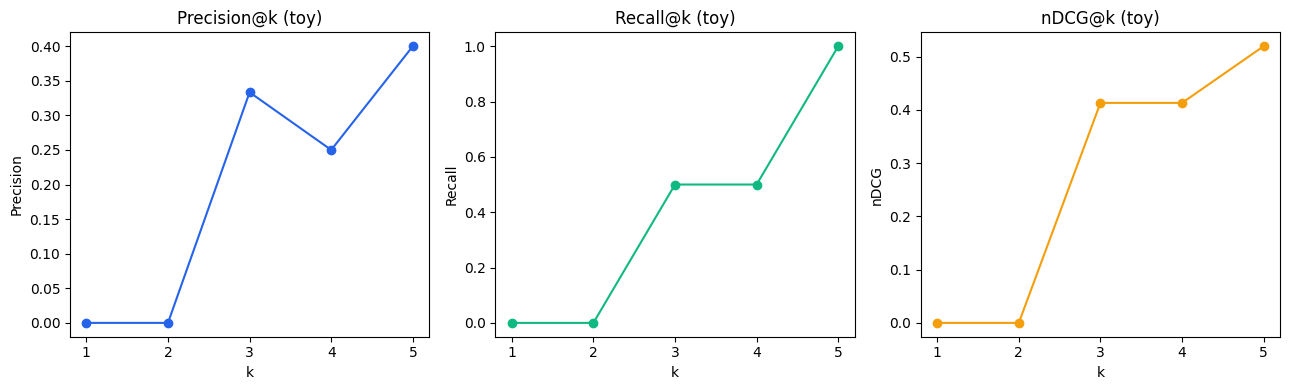

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
axes[0].plot(df_curves["k"], df_curves["precision@k"], marker="o", color="#2563eb")
axes[0].set_title("Precision@k (toy)")
axes[0].set_xlabel("k"); axes[0].set_ylabel("Precision")

axes[1].plot(df_curves["k"], df_curves["recall@k"], marker="o", color="#10b981")
axes[1].set_title("Recall@k (toy)")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Recall")

axes[2].plot(df_curves["k"], df_curves["ndcg@k"], marker="o", color="#f59e0b")
axes[2].set_title("nDCG@k (toy)")
axes[2].set_xlabel("k"); axes[2].set_ylabel("nDCG")

plt.tight_layout()
plt.show()

# Avaliando rankings simulados no BEIR

Vamos:
1. Carregar `corpus`, `queries`, `qrels` de um dataset (ex.: `scifact`).
2. Selecionar um split (ex.: `test`).
3. Criar rankings simulados para cada `query_id`:
   - Aleatório.
   - “Quase-oráculo” (coloca relevantes primeiro, mas embaralha e injeta ruído com não-relevantes).
   - Ruim (coloca não-relevantes no topo e relevantes no fim).
4. Avaliar com `evaluate_predictions` e comparar.

In [5]:
dataset_name = "fiqa"  # pode trocar para "fiqa" ou "nfcorpus"

data_root = repo_root / "data" / dataset_name / "processed" / "beir"
corpus_df, queries_df, qrels_df = load_beir_dataset(data_root)

split = select_split(qrels_df, prefer=("test","dev","validation","train"))
qrels_split = qrels_df[qrels_df["split"] == split].copy()

print(dataset_name, "| split:", split)
print("qrels_split:", len(qrels_split))
print("queries:", len(queries_df), "| corpus:", len(corpus_df))

# Índices úteis
doc_ids = corpus_df["doc_id"].astype(str).tolist()
query_ids = sorted(qrels_split["query_id"].astype(str).unique().tolist())

# Mapa gold por query: doc_id -> score
gold_map = {}
for row in qrels_split.itertuples(index=False):
    qid = str(getattr(row, "query_id"))
    did = str(getattr(row, "doc_id"))
    sc  = int(getattr(row, "score", 1))
    gold_map.setdefault(qid, {})[did] = sc

len(query_ids), len(doc_ids)

fiqa | split: test
qrels_split: 1706
queries: 6648 | corpus: 57638


(648, 57638)

## Gerando rankings simulados

- Aleatório: embaralha todos os documentos para cada query.
- Quase-oráculo: começa com os relevantes (embaralhados entre si), depois injeta não-relevantes aleatórios até k grande.
- Ruim: faz o contrário do oráculo (coloca não-relevantes antes).

In [6]:
import random

def build_random_preds(query_ids, doc_ids, k=100):
    preds = {}
    for qid in query_ids:
        r = doc_ids.copy()
        random.shuffle(r)
        ranked = r[:k]
        preds[qid] = [(d, float(k - i)) for i, d in enumerate(ranked)]  # score decrescente apenas para ordenação estável
    return preds

def build_almost_oracle_preds(query_ids, doc_ids, gold_map, k=100):
    preds = {}
    for qid in query_ids:
        gains = gold_map.get(qid, {})
        gold_docs = [d for d, s in gains.items() if s > 0]
        non_rels = [d for d in doc_ids if d not in gains]
        random.shuffle(gold_docs)
        random.shuffle(non_rels)
        ranked = gold_docs + non_rels
        ranked = ranked[:k]
        preds[qid] = [(d, float(k - i)) for i, d in enumerate(ranked)]
    return preds

def build_bad_preds(query_ids, doc_ids, gold_map, k=100):
    preds = {}
    for qid in query_ids:
        gains = gold_map.get(qid, {})
        gold_docs = [d for d, s in gains.items() if s > 0]
        non_rels = [d for d in doc_ids if d not in gains]
        random.shuffle(gold_docs)
        random.shuffle(non_rels)
        ranked = non_rels + gold_docs
        ranked = ranked[:k]
        preds[qid] = [(d, float(k - i)) for i, d in enumerate(ranked)]
    return preds

random.seed(42)
preds_random = build_random_preds(query_ids, doc_ids, k=100)
preds_oracle = build_almost_oracle_preds(query_ids, doc_ids, gold_map, k=100)
preds_bad = build_bad_preds(query_ids, doc_ids, gold_map, k=100)

len(preds_random), len(preds_oracle), len(preds_bad)

(648, 648, 648)

## Avaliando e comparando

Usamos `evaluate_predictions` para obter as métricas agregadas por `k`.

In [7]:
res_random = evaluate_predictions(preds_random, qrels_split, ks=(1,3,5,10,20,50,100))
res_oracle = evaluate_predictions(preds_oracle, qrels_split, ks=(1,3,5,10,20,50,100))
res_bad = evaluate_predictions(preds_bad, qrels_split, ks=(1,3,5,10,20,50,100))

def tag(df, name):
    out = df.copy()
    out["run"] = name
    return out

res_all = pd.concat([
    tag(res_random, "random"),
    tag(res_oracle, "almost_oracle"),
    tag(res_bad, "bad"),
], ignore_index=True)

res_all

,k,MRR,nDCG,MAP,Recall,Precision,run
0,1,0.000000,0.000000,0.00000,0.000000,0.000000,random
1,3,0.000000,0.000000,0.00000,0.000000,0.000000,random
2,5,0.000000,0.000000,0.00000,0.000000,0.000000,random
3,10,0.000000,0.000000,0.00000,0.000000,0.000000,random
4,20,0.000000,0.000000,0.00000,0.000000,0.000000,random
5,50,0.000175,0.000351,0.00004,0.001044,0.000093,random
6,100,0.000175,0.000351,0.00004,0.001044,0.000046,random
7,1,1.000000,1.000000,1.00000,0.576736,1.000000,almost_oracle
8,3,1.000000,1.000000,1.00000,0.909221,0.679012,almost_oracle
9,5,1.000000,1.000000,1.00000,0.972158,0.477160,almost_oracle


## Curvas por k (comparação)

Vamos plotar MRR, nDCG, MAP, Recall e Precision para comparar os três rankings.

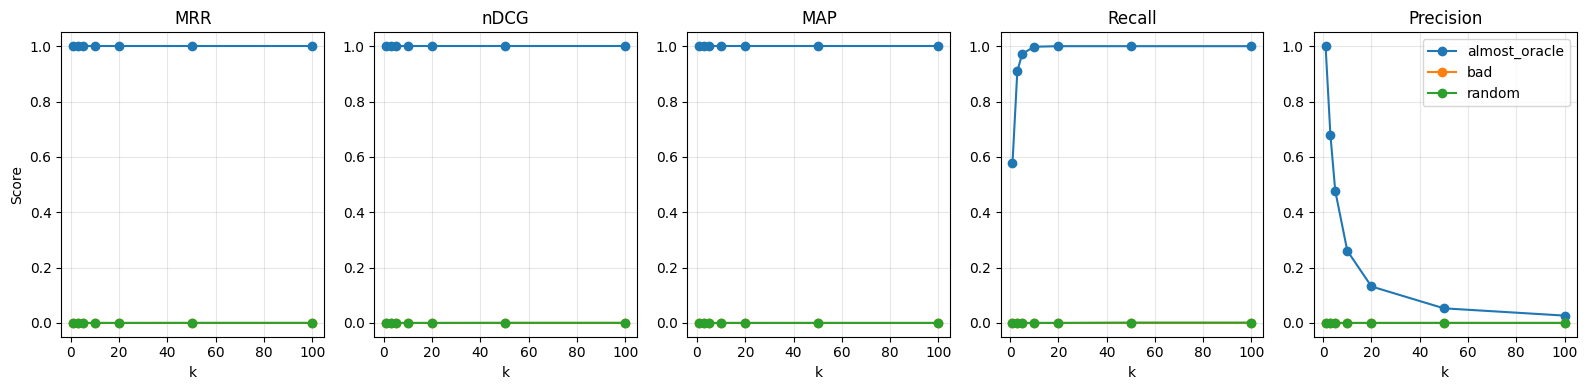

In [8]:
import matplotlib.pyplot as plt

metrics_cols = ["MRR", "nDCG", "MAP", "Recall", "Precision"]
runs = sorted(res_all["run"].unique())
ks = sorted(res_all["k"].unique())

fig, axes = plt.subplots(1, len(metrics_cols), figsize=(16, 4), sharex=True)
for ax, m in zip(axes, metrics_cols):
    for r in runs:
        sub = res_all[res_all["run"] == r].sort_values("k")
        ax.plot(sub["k"], sub[m], marker="o", label=r)
    ax.set_title(m)
    ax.set_xlabel("k")
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel("Score")
axes[-1].legend()
plt.tight_layout()
plt.show()

## Zoom em uma query

Para uma `query_id`, vamos comparar:
- Ranking `random` vs `almost_oracle` vs `bad`
- Métricas por k e visualização de quantos relevantes aparecem cedo

In [9]:
# escolher uma query que tenha relevantes
qid_candidates = [qid for qid in query_ids if any(s > 0 for s in gold_map.get(qid, {}).values())]
qid0 = qid_candidates[0] if qid_candidates else query_ids[0]
gains0 = gold_map.get(qid0, {})

def ranked_ids(preds, qid):
    return [d for d, _ in preds[qid]]

rank_random = ranked_ids(preds_random, qid0)
rank_oracle = ranked_ids(preds_oracle, qid0)
rank_bad = ranked_ids(preds_bad, qid0)

def profile(name, ranked, gains, k=10):
    gold = {d for d, s in gains.items() if s > 0}
    print(f"[{name}] k={k}")
    print("MRR:", round(mrr_at_k(ranked, gold, k=k), 3),
          "| MAP:", round(average_precision_at_k(ranked, gold, k=k), 3),
          "| nDCG:", round(ndcg_at_k(ranked, gains, k=k), 3),
          "| P@k:", round(precision_at_k(ranked, gold, k=k), 3),
          "| R@k:", round(recall_at_k(ranked, gold, k=k), 3))
    print("Top-10 (doc_id, rel?):", [(d, int(d in gold)) for d in ranked[:10]])
    print()

profile("random", rank_random, gains0, k=10)
profile("almost_oracle", rank_oracle, gains0, k=10)
profile("bad", rank_bad, gains0, k=10)

[random] k=10
MRR: 0.0 | MAP: 0.0 | nDCG: 0.0 | P@k: 0.0 | R@k: 0.0
Top-10 (doc_id, rel?): [('277190', 0), ('212589', 0), ('86040', 0), ('52004', 0), ('15696', 0), ('213129', 0), ('308764', 0), ('421169', 0), ('488615', 0), ('267592', 0)]

[almost_oracle] k=10
MRR: 1.0 | MAP: 1.0 | nDCG: 1.0 | P@k: 0.2 | R@k: 1.0
Top-10 (doc_id, rel?): [('480749', 1), ('181942', 1), ('64634', 0), ('448999', 0), ('485331', 0), ('353138', 0), ('349554', 0), ('195348', 0), ('461042', 0), ('36282', 0)]

[bad] k=10
MRR: 0.0 | MAP: 0.0 | nDCG: 0.0 | P@k: 0.0 | R@k: 0.0
Top-10 (doc_id, rel?): [('349603', 0), ('534607', 0), ('99409', 0), ('454813', 0), ('384022', 0), ('384168', 0), ('41625', 0), ('468131', 0), ('175504', 0), ('95340', 0)]



## Dicas e boas práticas

- Em tarefas com poucos relevantes por query, MRR@k tende a ser muito informativa (primeiro relevante cedo).
- nDCG@k é a mais sensível a ganhos (relevâncias > 1) e à posição de múltiplos relevantes.
- MAP@k recompensa consistência em trazer relevantes cedo e com frequência.
- Sempre verifique:
  - Distribuição de `score` em `qrels` (binário vs graus).
  - Integridade: `doc_id` e `query_id` entre `qrels`, `corpus` e `queries`.
- Use `ks` coerentes com o uso (ex.: interfaces paginadas vs top-10 vs top-1000).